In [2]:
import numpy as np
import scipy
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import os
import bisect
import pickle
import glob
import CDOconcat
import json


#%matplotlib widget


def basic_1D(figsize=[6,4], ydata=[None], xdata=None, ylabel=None, xlabel=None, title=None, legendloc=None,
             yscale="linear", ylinthresh=1, xscale="linear", legendfontsize="small", colorlist=None, labels=None, linestyles=None,
             ymin=None, ymax=None, xmin=None, xmax=None, savename=None, suffix=None, plotfoldername=None):
    
    fig = plt.figure(figsize=figsize)
    kwargs = {}

    for i, data in enumerate(ydata):
        if colorlist is not None:
            kwargs.update({"c": colorlist[i]})

        if labels is not None:
            kwargs.update({"label": labels[i]})
        
        if linestyles is not None:
            kwargs.update({"ls": linestyles[i]})

        plt.plot(xdata, data, **kwargs)

    axes = plt.gca()
    if yscale == "symlog":
        axes.set_yscale(yscale, linthresh=ylinthresh)
    else:
        axes.set_yscale(yscale)

    axes.set_xscale(xscale)
    axes.set_ylim([ymin, ymax])
    axes.set_xlim([xmin, xmax])
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    if title is not None: plt.title(title)
    if legendloc is not None: plt.legend(loc=legendloc, fontsize=legendfontsize)
    
    if savename:
        if suffix is not None: savename += suffix
        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
    else:
        plt.show()


# WIP
def twinx_1D(figsize=[6,4], ydata=[None], xdata=None, ylabel=None, xlabel=None, title=None, legendloc=None,
             yscale="linear", ylinthresh=1, xscale="linear", legendfontsize="small", colorlist=None, labels=None, linestyles=None,
             ymin=None, ymax=None, xmin=None, xmax=None, savename=None, suffix=None, plotfoldername=None):
    
    fig = plt.figure(figsize=figsize)
    kwargs = {}

    for i, data in enumerate(ydata):
        if colorlist is not None:
            kwargs.update({"c": colorlist[i]})

        if labels is not None:
            kwargs.update({"label": labels[i]})
        
        if linestyles is not None:
            kwargs.update({"ls": linestyles[i]})

        plt.plot(xdata, data, **kwargs)

    axes = plt.gca()
    if yscale == "symlog":
        axes.set_yscale(yscale, linthresh=ylinthresh)
    else:
        axes.set_yscale(yscale)

    axes.set_xscale(xscale)
    axes.set_ylim([ymin, ymax])
    axes.set_xlim([xmin, xmax])
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    if title is not None: plt.title(title)
    if legendloc is not None: plt.legend(loc=legendloc, fontsize=legendfontsize)
    
    if savename:
        if suffix is not None: savename += suffix
        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
    else:
        plt.show()


def basic_2D(data, figsize=[6,5], xgrid=None, ygrid=None, savename=None, yscale="linear",
             title=None, cbarlabel=None, plotfoldername=None, ymin=None, ymax=None,
             normalization="lin", linthresh=1e-2, xlabel=None, ylabel=None,
             datamin=None, datamax=None, logdiff=None, levels=None, cmap=None):

    if data.max() < 0 and datamax is None:
        print("Warning! Datamax < 0, switching to symlog")
        normalization = "symlog"
    
    data[data > 1e308] = 0
    data[data == float('+inf')] = 0
    
    if datamax is None:
        datamax = data.max()
    
    if datamin is None:
        datamin = data.min()

    if levels is None:
        levels = 11
        
    if cmap is None:
        cmap = plt.colormaps['inferno']
        
    fig = plt.figure(figsize=figsize)
    axes = plt.subplot(1, 1, 1)
    
    if normalization == "log":
        if logdiff is None:
            ld = math.log10(datamax) - 1
            if ld > 10:
                logdiff = ld
            else:
                logdiff = 10
        
        logmax = math.ceil(np.log10(datamax))
        logmin = logmax - logdiff
        numofticks = logdiff
        div = logdiff // numofticks
        power = np.arange((logmax - (numofticks * div)), logmax, div)
        array = np.zeros(len(power)) + 10.
        ticks = np.power(array, power)
        levels1 = np.logspace(logmin, logmax, levels, base=10.0)
        formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
        norm = matplotlib.colors.LogNorm(vmin=10 ** (logmin), vmax=datamax)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm, cmap=cmap)
        cbar = plt.colorbar(ticks=ticks, format=formatter)
        cbar.formatter = matplotlib.ticker.LogFormatterExponent(base=10)
        cbar.update_ticks()
    elif normalization == "lin":
        levels2 = np.linspace(datamin, datamax, levels)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels2, cmap=cmap, vmin=datamin, vmax=datamax)
        cbar = plt.colorbar(plot)
    elif normalization == "symlog":
        norm = matplotlib.colors.SymLogNorm(linthresh=linthresh)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels, norm=norm, cmap=plt.colormaps['RdBu'], vmax=datamax, vmin=-datamax)
        cbar = plt.colorbar()

    axes = plt.gca()
    axes.set_facecolor('black')
    cbar.set_label(cbarlabel)
    axes.set_ylim(ymin, ymax)
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    axes.set_title(title)
    axes.set_yscale(yscale)
    
    if savename:
        plt.savefig(plotfoldername + savename + ".png", dpi=150)
        plt.close(fig)
    

def calculate_indices(timegrid, start, ms_step):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames

    
def newest_output(path):
    list2 = glob.glob(path + 'output_??_.h5')
    if len(list2) > 0:
        return max( glob.glob(path + 'output_??_.h5'))
    else:
        return max( glob.glob(path + 'output_?_.h5'))


def calculate_index_array(timegrid, array):
    indices = np.zeros(len(array), dtype=np.intc)
    for i, j in enumerate(array):
        indices[i] = int(bisect.bisect_left(timegrid, j))
        
    return indices



TDK/  
- 2018_0Ar_0rec/  
- 2018_0Ar_6e24rec/  
- 2018_Ar_0rec/  
- 2018_lowres_diff30/  
- 2018_lowres_diff1000/  
- Ar_10ms_tr_off/  
- ref_VDE_8ms_10cm_6e24rec_diff1000/  
- VDE_0.1Ar/  
- VDE_1cm/  
- VDE_1ms/  
- VDE_2e24rec/  
- VDE_6e23rec/  
- VDE_20ms/  
- VDE_diff330/  
- VDE_diff3300/  

VDE/  
- lessCompton/ - gamma flux 1e10 - original 1e18  
- lessCompton2/ - gamma flux 1e15  
- kin_ava/ - pCutAvalanche - 2.5  
- kin_ava2/ - pCutAvalanche - 0.01  

In [3]:
parentfolder = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/"
#folder = parentfolder + "TDK/" + "2018_lowres_diff30/"
folder = parentfolder + "VDE/kin_ava2/"
plt.close('all')

In [4]:
# read data
fnames = []
try:
    newest = newest_output(folder)
    print(newest)
    numoffiles = int(newest.split("_")[-2])
except:
    print("Finding newest output unsuccesful")
    
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    fnames.append(fname)
    
# print(fnames)
concat = CDOconcat.CustomConcat(fnames)
endtime = '{0:.0f}'.format(concat.timegrid_ms[-1])
concat.info()


C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Data/VDE/kin_ava2\output_12_.h5
Simulation time from 0.0 ms to 150.001 ms
Minor radius: [2.431159] m
Number of radial grid cells: 20
Radial step (dr): 0.12155795 m
Hottailgrid enabled: True
Resolution: (100, 1)
Runawaygrid enabled: True
Resolution: (180, 15)


In [10]:
# Pickle dump to binary and next line is pickle load from binary, it's faster than doing the conatenation
pickle.dump(concat, open(folder + "CDO" + endtime + ".dump", "wb"))

In [3]:
concat = pickle.load(open(folder + "CDO510.dump" , "rb"))
concat.info()

Simulation time from 0.001 ms to 510.1201 ms
Minor radius: [2.93] m
Number of radial grid cells: 20
Radial step (dr): 0.14650000000000002 m
Hottailgrid enabled: True
Resolution: (140, 1)
Runawaygrid enabled: True
Resolution: (120, 15)


In [7]:
# color_list = plt.cm.inferno(np.linspace(0.9, 0, len(ydatalist_1D)))
# color_list = plt.cm.viridis(np.linspace(0.95, 0, len(ydatalist_1D)))
# "colorlist": color_list,

language = "EN HU"  # "HU" or "EN" or other custom dictinary, 
                    # add "notitle" if no title is needed for the 2D plots 
latex = False
sansserif = True
figures = True
notzoomed = True
zoomed = False
zt = 150  # zoomed time will be the [0, zt] millisecond range
distributions2D = False
vids = False
vids2D = False
if (concat.I_re[-1] + concat.I_hot[-1]) > 2e5:
    distributions = True
else:
    distributions = False
    
if concat.density_Ar.size > 0: 
    argon = True 
else: 
    argon = False

"""General figure settings"""
if 1:
    plt.rcParams.update({"xtick.direction" : "in", 
                        "xtick.labelsize" : "small",
                        "xtick.major.size" : 5,
                        "xtick.major.width" : 0.7,
                        "xtick.minor.size" : 2.5,
                        "xtick.minor.width" : 0.5,
                        "xtick.minor.visible" : True,
                        "xtick.top" : False,
                        "ytick.direction" : "in",
                        "ytick.labelsize" : "small",
                        "ytick.major.size" : 5,
                        "ytick.major.width" : 0.7,
                        "ytick.minor.size" : 2.5,
                        "ytick.minor.width" : 0.5,
                        "ytick.minor.visible" : True,
                        "ytick.right" : True,
                        "legend.frameon" : False,
                        'font.size': 20, 
                        "figure.dpi" : 150,
                        'lines.linewidth': 1.5,
                        'figure.constrained_layout.use': True,
                        'image.cmap': 'inferno'})

if latex:
    plt.rcParams.update({"text.usetex": True, "text.latex.preamble" : r"\usepackage{amsmath} \usepackage{amssymb}"})
    if not sansserif:
        plt.rcParams.update({"font.family" : "serif",
                             "font.serif" : "STIXGeneral", 
                             "mathtext.fontset" : "stix"})
    else: 
        plt.rcParams.update({"font.family": "sans-serif",
                             "text.latex.preamble": r'\usepackage{cmbright}',
                             "mathtext.fontset" : "stixsans",
                             "font.size": 22})
else: plt.rcParams.update({"text.usetex": False, 
                           "font.family": "sans-serif"})

# Figure sizes
FS_1D_LINE_GENERAL = [6, 5]
FS_1D_DISTRIBUTIONS = [7, 5]
FS_1D_PROFILES = [7, 5]
FS_2D_PCMESH = [6, 5]

EN_R = "Minor radius [m]"
EN_T = "Time [ms]"
EN_P = "Momentum normalized to " r'm$_e$c [-]'
F_EN = folder + "EN_" + endtime + "/"
F_EN_NT = folder + "EN_NT_" + endtime + "/"

HU_R = "Kissugár [m]"
HU_T = "Idő [ms]"
HU_P = "Lendület " r'm$_e$c' " egységben [-]"
F_HU = folder + "HU_" + endtime + "/"
F_HU_NT = folder + "HU_NT_" + endtime + "/"

plotfoldernames = []
if "notitle" in language:
    if "EN" in language: plotfoldernames.append(F_EN_NT)
    if "HU" in language: plotfoldernames.append(F_HU_NT)
    if "EN" in language: plotfoldernames.append(F_EN_NT + "distributions/")
    if "HU" in language: plotfoldernames.append(F_HU_NT + "distributions/")
else:
    if "EN" in language: plotfoldernames.append(F_EN)
    if "HU" in language: plotfoldernames.append(F_HU)
    if "EN" in language: plotfoldernames.append(F_EN + "distributions/")
    if "HU" in language: plotfoldernames.append(F_HU + "distributions/")

for plotfoldername in plotfoldernames:
    if os.path.exists(plotfoldername):
        pass
    else:
        os.mkdir(plotfoldername)



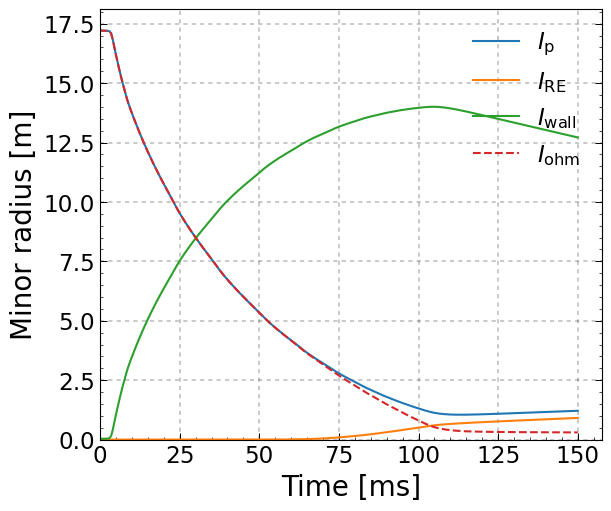

In [8]:
# Áramok
plt.rcParams.update({"axes.grid": True, "grid.color": "black", "grid.linewidth": 0.3, "grid.linestyle": (0, (10, 10))})
with matplotlib.rc_context({"figure.dpi" : 100}):
    currentslist = [concat.I_p / 1e6,
                    (concat.I_re + concat.I_hot) / 1e6, 
                    concat.I_wall / 1e6, 
                    concat.I_ohm / 1e6]
        
    currents = {"figsize": FS_1D_LINE_GENERAL, 
                "ydata": currentslist, 
                "ymin": 0, "ymax": None,
                "xdata": concat.timegrid_ms,
                "xmin": 0, "xmax": None, 
                "linestyles": ["-", "-", "-", "--"],
                "legendloc": "upper right",
                "ylabel": EN_R,
                "xlabel": EN_T,
                "labels": [r"$I_{\rm p}$", r"$I_{\rm RE}$", r"$I_{\rm wall}$", r"$I_{\rm ohm}$"],
                "savename": None}
    basic_1D(**currents)

In [9]:
timelist1 = [1, 5, 10, 25, 50, 75, 100, 125, 150]
timelist2 = range(60, 151, 15)
timestringlist1 = []
timestringlist2 = []
for time in timelist1: 
    timestringlist1.append(str(time) + " ms")
for time in timelist2: 
    timestringlist2.append(str(time) + " ms")

In [10]:
################# 1D ##################
plt.rcParams.update({"axes.grid": True, "grid.color": "black", "grid.linewidth": 0.3, "grid.linestyle": (0, (10, 10))})

""" Currents 1D """
if figures:
    ydatalist_1D = [concat.I_p / 1e6,
                    (concat.I_re + concat.I_hot) / 1e6, 
                    concat.I_wall / 1e6, 
                    concat.I_ohm / 1e6]
    
    kwargs1D = {"figsize": FS_1D_LINE_GENERAL, 
                "ydata": ydatalist_1D, 
                "ymin": 0, "ymax": None,
                "xdata": concat.timegrid_ms,
                "xmin": 0, "xmax": None, 
                "linestyles": ["-", "-", "-", "--"],
                "legendloc": "upper right",
                "savename": "0_currents"}
    
    if "EN" in language:
        kwargs1D.update({"ylabel": "Currents [MA]",
                         "xlabel": EN_T,
                         "title": None,
                         "labels": [r"$I_{\rm p}$", r"$I_{\rm RE}$", r"$I_{\rm wall}$", r"$I_{\rm ohm}$"],
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_EN_NT})
        if notzoomed: basic_1D(**kwargs1D)
        if zoomed:
            kwargs1D.update({"xmax": zt, "suffix": "_" + str(zt)})
            basic_1D(**kwargs1D)
    
    if "HU" in language:
        kwargs1D.update({"ylabel": "Áramok [MA]",
                         "xlabel": HU_T,
                         "title": None,
                         "xmax": None,
                         "suffix": None,
                         "labels": [r"$I_{\rm p}$", r"$I_{\rm RE}$", r"$I_{\rm fal}$", r"$I_{\rm ohm}$"],
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_HU_NT})
        if notzoomed: basic_1D(**kwargs1D)
        if zoomed:
            kwargs1D.update({"xmax": zt, "suffix": "_" + str(zt)})
            basic_1D(**kwargs1D)

    del(kwargs1D)

""" 1D profiles """
# Electron temperature
if figures:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=timelist1)
    ydata = concat.T_cold
    ydatalist_1D = []
    for i in indices: ydatalist_1D.append(ydata[i, :])
    color_list = plt.cm.inferno(np.linspace(0.9, 0.1, len(ydatalist_1D)))
    
    kwargs1D = {"figsize": FS_1D_PROFILES, 
                "ydata": ydatalist_1D, 
                "yscale": "log",
                "ymin": None, "ymax": None,
                "xdata": concat.radialgrid,
                "xmin": 0, "xmax": None, 
                "linestyles": None,
                "legendloc": "upper right",
                "legendfontsize": 'x-small',
                "labels": timestringlist1,
                "savename": "1_Tcold_LINE",
                "colorlist": color_list}
    
    if "EN" in language:
        kwargs1D.update({"ylabel": "Electron temperature [eV]",
                         "xlabel": EN_R,
                         "title": None,
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_1D(**kwargs1D)
    
    if "HU" in language:
        kwargs1D.update({"ylabel": "Elektronhőmérséklet [eV]",
                         "xlabel": HU_R,
                         "title": None,
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_1D(**kwargs1D)

    del(kwargs1D)

# total current density
if figures:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=timelist1)
    ydata = concat.j_tot
    ydatalist_1D = []
    for i in indices: ydatalist_1D.append(ydata[i, :])
    color_list = plt.cm.inferno(np.linspace(0.9, 0.1, len(ydatalist_1D)))
    
    kwargs1D = {"figsize": FS_1D_PROFILES, 
                "ydata": ydatalist_1D, 
                "yscale": "log",
                "ymin": None, "ymax": None,
                "xdata": concat.radialgrid,
                "xmin": 0, "xmax": None, 
                "linestyles": None,
                "legendloc": "lower left",
                "legendfontsize": 'x-small',
                "labels": timestringlist1,
                "savename": "j_tot_LINE",
                "colorlist": color_list}
    
    if "EN" in language:
        kwargs1D.update({"ylabel": r"Total current density [A/m$^2$]",
                         "xlabel": EN_R,
                         "title": None,
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_1D(**kwargs1D)
    
    if "HU" in language:
        kwargs1D.update({"ylabel": r"Teljes áramsűrűség [A/m$^2$]",
                         "xlabel": HU_R,
                         "title": None,
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_1D(**kwargs1D)

    del(kwargs1D)

# runaway current density
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=timelist2)
    ydata = concat.j_re
    ydatalist_1D = []
    for i in indices: ydatalist_1D.append(ydata[i, :])
    color_list = plt.cm.viridis(np.linspace(0.95, 0, len(ydatalist_1D)))
    
    kwargs1D = {"figsize": FS_1D_PROFILES, 
                "ydata": ydatalist_1D, 
                "yscale": "log",
                "ymin": 1e2, "ymax": None,
                "xdata": concat.radialgrid,
                "xmin": 0, "xmax": None, 
                "linestyles": None,
                "legendloc": "lower left",
                "legendfontsize": 'x-small',
                "labels": timestringlist2,
                "savename": "j_re_LINE",
                "colorlist": color_list}
    
    if "EN" in language:
        kwargs1D.update({"ylabel": "Runaway current density " r"[A/m$^2$]",
                         "xlabel": EN_R,
                         "title": None,
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_1D(**kwargs1D)
    
    if "HU" in language:
        kwargs1D.update({"ylabel": "Elfutóelektron-áramsűrűség " r"[A/m$^2$]",
                         "xlabel": HU_R,
                         "title": None,
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_1D(**kwargs1D)

    del(kwargs1D)

# runaway particle density
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=timelist2)
    ydata = concat.n_re
    ydatalist_1D = []
    for i in indices: ydatalist_1D.append(ydata[i, :])
    color_list = plt.cm.viridis(np.linspace(0.95, 0, len(ydatalist_1D)))
    
    kwargs1D = {"figsize": FS_1D_PROFILES, 
                "ydata": ydatalist_1D, 
                "yscale": "log",
                "ymin": 1e12, "ymax": None,
                "xdata": concat.radialgrid,
                "xmin": 0, "xmax": None, 
                "linestyles": None,
                "legendloc": "lower left",
                "legendfontsize": 'x-small',
                "labels": timestringlist2,
                "savename": "n_re_LINE",
                "colorlist": color_list}
    
    if "EN" in language:
        kwargs1D.update({"ylabel": "Runaway electron density " r"[m$^{-3}$]",
                         "xlabel": EN_R,
                         "title": None,
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_1D(**kwargs1D)
    
    if "HU" in language:
        kwargs1D.update({"ylabel": "Elfutóelektron-sűrűség " r"[m$^{-3}$]",
                         "xlabel": HU_R,
                         "title": None,
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_1D(**kwargs1D)

    del(kwargs1D)

""" Distributions """
# runaway momentum distributions
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=timelist2)
    for r_index in range(concat.radialgrid_length):
        ydata = concat.f_re_avg[:, r_index, :]
        ydatalist_1D = []
        for i in indices: ydatalist_1D.append(ydata[i, :])
        color_list = plt.cm.viridis(np.linspace(0.95, 0, len(ydatalist_1D)))
        
        kwargs1D = {"figsize": FS_1D_PROFILES, 
                    "ydata": ydatalist_1D, 
                    "yscale": "log",
                    "ymin": 1e7, "ymax": 1e13,
                    "xdata": concat.re_momentumgrid,
                    "xmin": 0, "xmax": 80, 
                    "linestyles": None,
                    "legendloc": "upper right",
                    "legendfontsize": 'x-small',
                    "labels": timestringlist2,
                    "savename": "distributions/f_re_avg_rindex_" + str(r_index),
                    "colorlist": color_list}
        
        if "EN" in language:
            kwargs1D.update({"ylabel": r"$\langle f_{RE}\rangle$ [m$^{-3}$]",
                            "xlabel": EN_P,
                            "title": "Momentum distribution r=" 
                                    + str(np.round(concat.radialgrid[r_index], 3)) + " m",
                            "plotfoldername": F_EN})
            if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_EN_NT})
            basic_1D(**kwargs1D)
        
        if "HU" in language:
            kwargs1D.update({"ylabel": r"$\langle f_{RE}\rangle$ [m$^{-3}$]",
                            "xlabel": HU_P,
                            "title": "Lendületeloszlás r=" 
                                    + str(np.round(concat.radialgrid[r_index], 3)) + " m",
                            "plotfoldername": F_HU})
            if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_HU_NT})
            basic_1D(**kwargs1D)

        del(kwargs1D)

# runaway momentum distributions - zoomed to ymin = 1e9 and xmax = 40 m_e*c
if distributions:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=timelist2)
    for r_index in range(concat.radialgrid_length):
        ydata = concat.f_re_avg[:, r_index, :]
        ydatalist_1D = []
        for i in indices: ydatalist_1D.append(ydata[i, :])
        color_list = plt.cm.viridis(np.linspace(0.95, 0, len(ydatalist_1D)))
        
        kwargs1D = {"figsize": FS_1D_PROFILES, 
                    "ydata": ydatalist_1D, 
                    "yscale": "log",
                    "ymin": 1e9, "ymax": 1e13,
                    "xdata": concat.re_momentumgrid,
                    "xmin": 0, "xmax": 40, 
                    "linestyles": None,
                    "legendloc": "upper right",
                    "legendfontsize": 'x-small',
                    "labels": timestringlist2,
                    "savename": "distributions/f_re_avg_zoomed_rindex_" + str(r_index),
                    "colorlist": color_list}
        
        if "EN" in language:
            kwargs1D.update({"ylabel": r"$\langle f_{RE}\rangle$ [m$^{-3}$]",
                            "xlabel": EN_P,
                            "title": "Momentum distribution r=" 
                                    + str(np.round(concat.radialgrid[r_index], 3)) + " m",
                            "plotfoldername": F_EN})
            if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_EN_NT})
            basic_1D(**kwargs1D)
        
        if "HU" in language:
            kwargs1D.update({"ylabel": r"$\langle f_{RE}\rangle$ [m$^{-3}$]",
                            "xlabel": HU_P,
                            "title": "Lendületeloszlás r=" 
                                    + str(np.round(concat.radialgrid[r_index], 3)) + " m",
                            "plotfoldername": F_HU})
            if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_HU_NT})
            basic_1D(**kwargs1D)

        del(kwargs1D)


C:\Users\lefer\AppData\Local\Temp\ipykernel_12120\4130152999.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


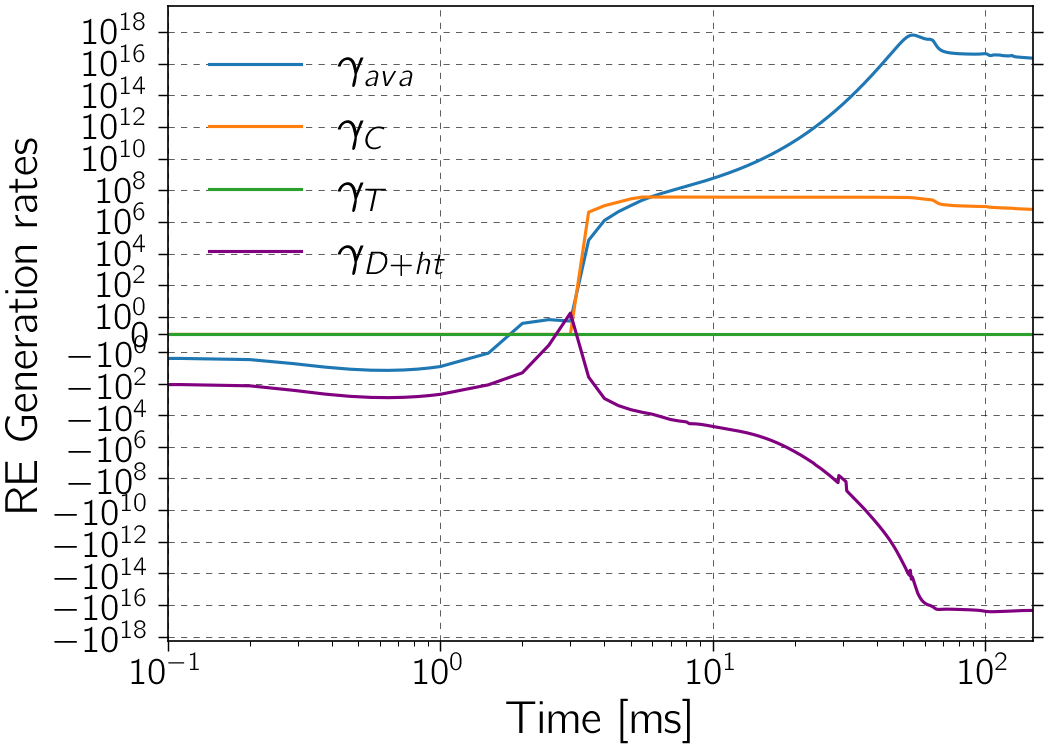

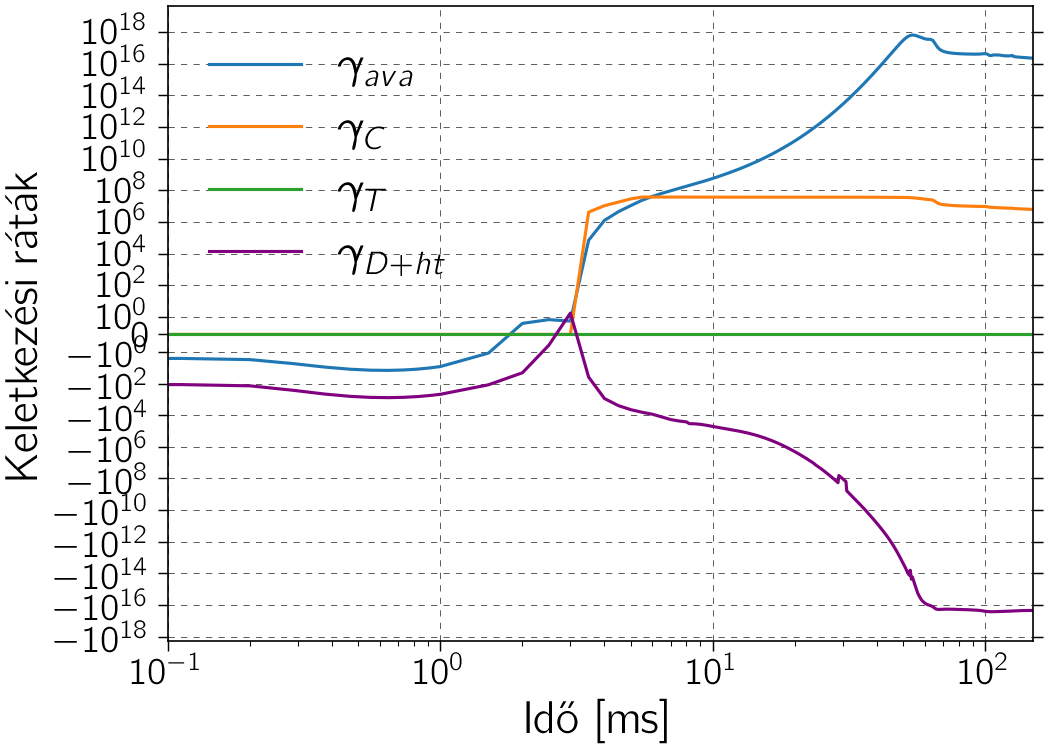

In [20]:
# TESTING 1D
plt.rcParams.update({"axes.grid": True, "grid.color": "black", "grid.linewidth": 0.3, "grid.linestyle": (0, (10, 10))})

# runaway momentum distributions
if 1:
    indices = calculate_index_array(timegrid=concat.timegrid_ms, array=timelist2)
    ydatalist_1D = [np.sum(concat.gammaAva * concat.n_re, axis=1) / len(concat.radialgrid),
                    np.sum(concat.gammaCompton, axis=1) / len(concat.radialgrid),
                    np.sum(concat.gammaTritium, axis=1) / len(concat.radialgrid),
                    np.sum(concat.flux_to_RE, axis=1) / len(concat.radialgrid)]
    
    kwargs1D = {"figsize": [7, 5], 
                "ydata": ydatalist_1D, 
                "yscale": "symlog",
                "xscale": "log",
                "ylinthresh": 1,
                "ymin": None, "ymax": None,
                "xdata": concat.timegrid_ms,
                "xmin": 1e-1, "xmax": concat.timegrid_ms[-1], 
                "linestyles": None,
                "legendloc": "upper left",
                "legendfontsize": 'medium',
                "labels": [r"$\gamma_{ava}$", r"$\gamma_C$", r"$\gamma_T$", r"$\gamma_{D+ht}$"],
                "savename": None,
                "colorlist": ['#1f77b4', '#ff7f0e', '#2ca02c', 'purple']}
    
    if "EN" in language:
        kwargs1D.update({"ylabel": "RE Generation rates",
                        "xlabel": EN_T,
                        "title": None,
                        "plotfoldername": F_EN})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_1D(**kwargs1D)
    
    if "HU" in language:
        kwargs1D.update({"ylabel": "Keletkezési ráták",
                        "xlabel": HU_T,
                        "title": None,
                        "plotfoldername": F_HU})
        if "notitle" in language: kwargs1D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_1D(**kwargs1D)

    del(kwargs1D)



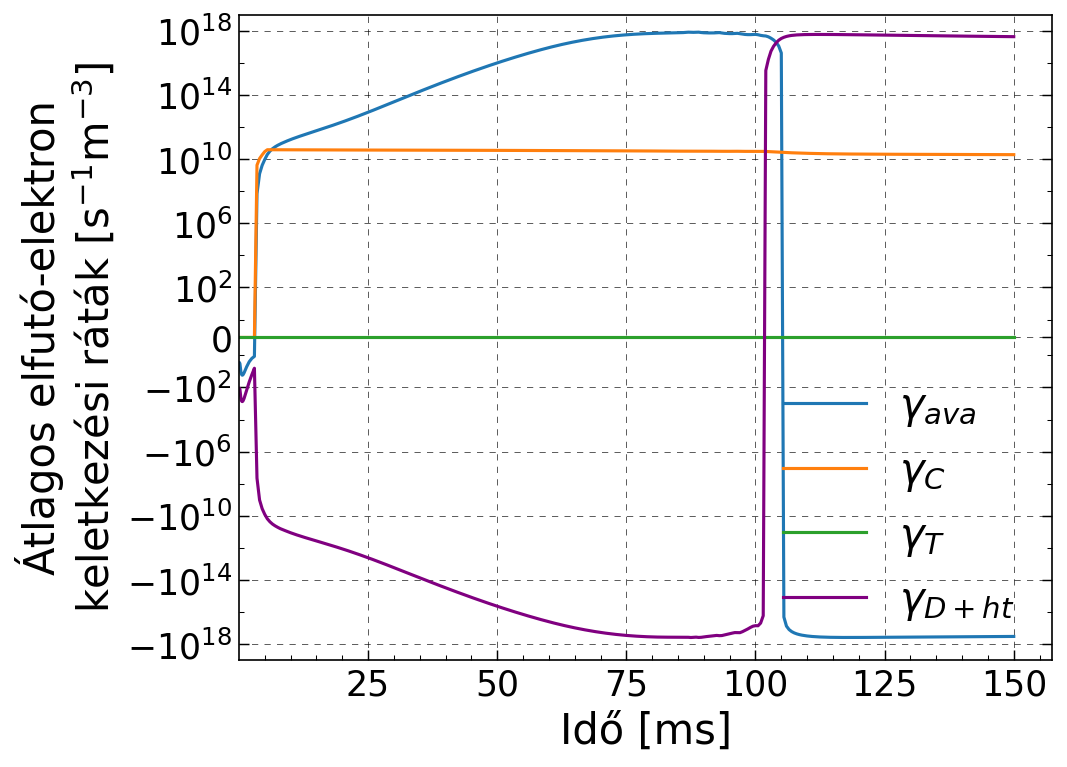

In [12]:
fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)  # rows, columns, index
# For example fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure
plt.plot(concat.timegrid_ms, np.sum(concat.gammaAva * concat.n_re, axis=1) / len(concat.radialgrid), label=r"$\gamma_{ava}$")
plt.plot(concat.timegrid_ms, np.sum(concat.gammaCompton, axis=1) / len(concat.radialgrid), label=r"$\gamma_C$")
plt.plot(concat.timegrid_ms, np.sum(concat.gammaTritium, axis=1) / len(concat.radialgrid), label=r"$\gamma_T$")
plt.plot(concat.timegrid_ms, np.sum(concat.flux_to_RE, axis=1) / len(concat.radialgrid), label=r"$\gamma_{D+ht}$", c="purple")

plt.ylabel("Átlagos elfutó-elektron\n" r"keletkezési ráták [s$^{-1}$m$^{-3}$]")
plt.xlabel('Idő [ms]')
plt.tick_params('x', labelbottom=True)

plt.ylim(-1e19, 1e19)
plt.yscale('symlog', linthresh=1)
plt.xlim(0.1, None)
#plt.xscale("log")
plt.yticks(ticks=[1e18, 1e14, 1e10, 1e6, 1e2, 0, -1e2, -1e6, -1e10, -1e14, -1e18])
plt.legend()
#plt.grid(which="both")
plt.show()

In [60]:

################# 2D ##################
plt.rcParams.update({"axes.grid": False, "grid.color": "cyan", "grid.linewidth": 0.4, "grid.linestyle": (0, (10, 10)),
                     "xtick.direction": "out", "ytick.direction": "out", "xtick.labelcolor": "k", "ytick.labelcolor": "k"})

""" Temperature 2D """
if figures:
    kwargs2D = {"figsize": FS_2D_PCMESH, 
                "data": concat.T_cold, 
                "datamin": None, "datamax": None,
                "ygrid": concat.timegrid_ms,
                "ymin": 0.001, "ymax": None,
                "xgrid": concat.radialgrid, 
                "cbarlabel": r"log$_{10}(T_{\rm cold}$/1eV) [-]",
                "normalization": "log",
                "logdiff": 5, "levels": 16,
                "cmap": None,
                "linthresh": None,
                "savename": "2_Tcold_log_time",
                "yscale": "log"}
    if "EN" in language:
        kwargs2D.update({"ylabel": EN_T,
                         "xlabel": EN_R,
                         "title": 'Electron temperature',
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_2D(**kwargs2D)
    
    if "HU" in language:
        kwargs2D.update({"ylabel": HU_T,
                         "xlabel": HU_R,
                         "title": "Elketronhőmérséklet",
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_2D(**kwargs2D)

    kwargs2D.update({"ymin": 0, "yscale": "linear", "savename": "2_Tcold_lin_time"})
    if "EN" in language:
        kwargs2D.update({"ylabel": EN_T,
                         "xlabel": EN_R,
                         "title": 'Electron temperature',
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_2D(**kwargs2D)
    
    if "HU" in language:
        kwargs2D.update({"ylabel": HU_T,
                         "xlabel": HU_R,
                         "title": "Elketronhőmérséklet",
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_2D(**kwargs2D)

    del(kwargs2D)

"""Total current density 2D"""
if figures:
    kwargs2D = {"figsize": FS_2D_PCMESH, 
                "data": concat.j_tot, 
                "datamin": None, "datamax": None,
                "ygrid": concat.timegrid_ms,
                "ymin": 0, "ymax": None,
                "xgrid": concat.radialgrid, 
                "cbarlabel": r"log$_{10}(j_{\rm tot}$/1Am$^{-2}$) [-]",
                "normalization": "log",
                "logdiff": 4, "levels": 17,
                "cmap": None,
                "linthresh": None,
                "savename": "3_jtot",
                "yscale": "linear"}
    if "EN" in language:
        kwargs2D.update({"ylabel": EN_T,
                         "xlabel": EN_R,
                         "title": 'Total current density',
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_2D(**kwargs2D)
    
    if "HU" in language:
        kwargs2D.update({"ylabel": HU_T,
                         "xlabel": HU_R,
                         "title": "Teljes áramsűrűség",
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_2D(**kwargs2D)

    del(kwargs2D)

"""Runaway current density 2D"""
if figures:
    kwargs2D = {"figsize": FS_2D_PCMESH, 
                "data": concat.j_re, 
                "datamin": None, "datamax": None,
                "ygrid": concat.timegrid_ms,
                "ymin": 0, "ymax": None,
                "xgrid": concat.radialgrid, 
                "cbarlabel": r"log$_{10}(j_{\rm RE}$/1Am$^{-2}$) [-]",
                "normalization": "log",
                "logdiff": 4, "levels": 17,
                "cmap": None,
                "linthresh": None,
                "savename": "4_jre",
                "yscale": "linear"}
    if "EN" in language:
        kwargs2D.update({"ylabel": EN_T,
                         "xlabel": EN_R,
                         "title": 'Runaway current density',
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_2D(**kwargs2D)
    
    if "HU" in language:
        kwargs2D.update({"ylabel": HU_T,
                         "xlabel": HU_R,
                         "title": "Elfutóeleketron-áramsűrűség",
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_2D(**kwargs2D)

    del(kwargs2D)
    
"""Ohmic current density 2D"""
if figures:
    kwargs2D = {"figsize": FS_2D_PCMESH, 
                "data": concat.j_ohm, 
                "datamin": None, "datamax": None,
                "ygrid": concat.timegrid_ms,
                "ymin": 0, "ymax": None,
                "xgrid": concat.radialgrid, 
                "cbarlabel": r"log$_{10}(j_{\rm ohm}$/1Am$^{-2}$) [-]",
                "normalization": "log",
                "logdiff": 4, "levels": 17,
                "cmap": None,
                "linthresh": None,
                "savename": "5_johm",
                "yscale": "linear"}
    if "EN" in language:
        kwargs2D.update({"ylabel": EN_T,
                         "xlabel": EN_R,
                         "title": 'Ohmic current density',
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_2D(**kwargs2D)
    
    if "HU" in language:
        kwargs2D.update({"ylabel": HU_T,
                         "xlabel": HU_R,
                         "title": "Ohmikus áramsűrűség",
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_2D(**kwargs2D)

    del(kwargs2D)
    

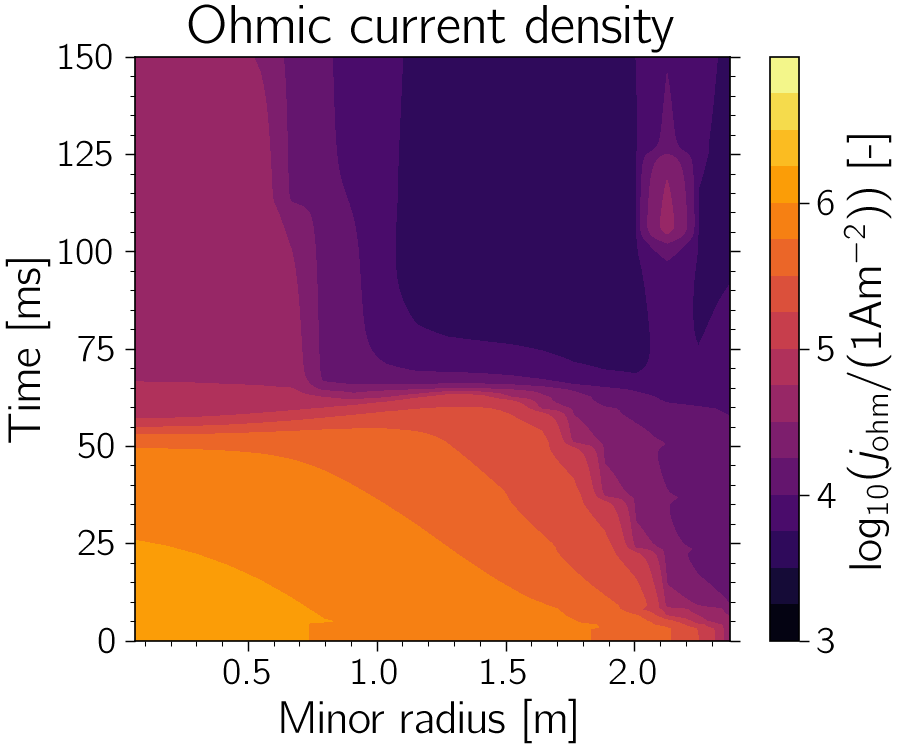

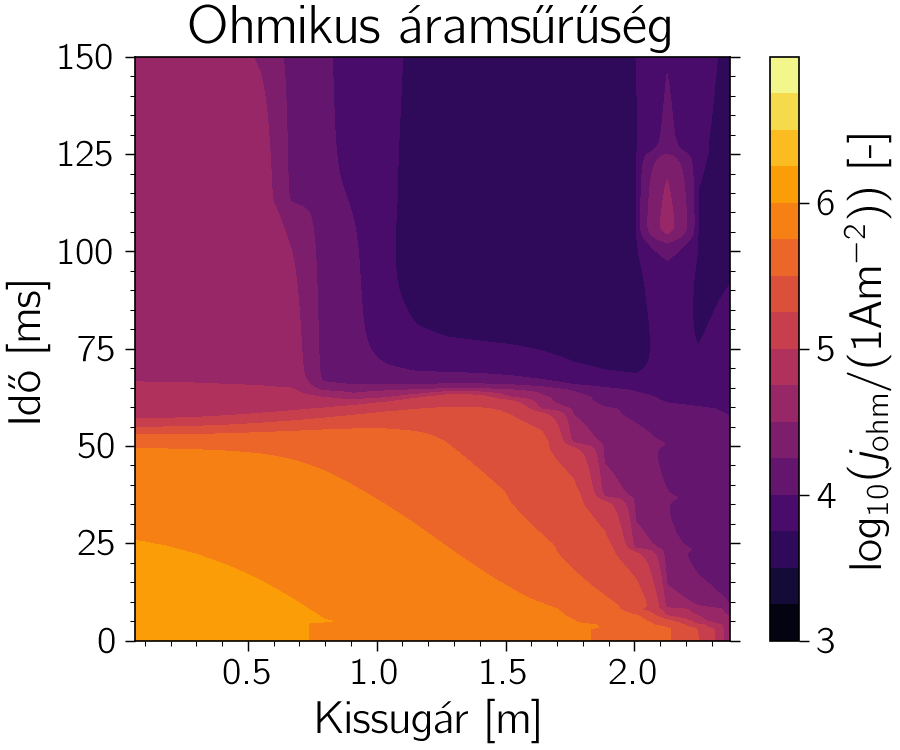

In [8]:
# TESTING 2D
plt.rcParams.update({"axes.grid": False, "grid.color": "cyan", "grid.linewidth": 0.4, "grid.linestyle": (0, (10, 10)),
                     "xtick.direction": "out", "ytick.direction": "out", "xtick.labelcolor": "k", "ytick.labelcolor": "k"})

"""Ohmic current density 2D"""
if figures:
    kwargs2D = {"figsize": FS_2D_PCMESH, 
                "data": concat.j_ohm, 
                "datamin": None, "datamax": 1e7,
                "ygrid": concat.timegrid_ms,
                "ymin": 0, "ymax": None,
                "xgrid": concat.radialgrid, 
                "cbarlabel": r"log$_{10}(j_{\rm ohm}$/(1Am$^{-2}$)) [-]",
                "normalization": "log",
                "logdiff": 4, "levels": 17,
                "cmap": None,
                "linthresh": None,
                "savename": None,
                "yscale": "linear"}
    if "EN" in language:
        kwargs2D.update({"ylabel": EN_T,
                         "xlabel": EN_R,
                         "title": 'Ohmic current density',
                         "plotfoldername": F_EN})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_EN_NT})
        basic_2D(**kwargs2D)
    
    if "HU" in language:
        kwargs2D.update({"ylabel": HU_T,
                         "xlabel": HU_R,
                         "title": "Ohmikus áramsűrűség",
                         "plotfoldername": F_HU})
        if "notitle" in language: kwargs2D.update({"title": None, "plotfoldername": F_HU_NT})
        basic_2D(**kwargs2D)

    del(kwargs2D)


Text(0.5, 1.0, 'log$_{10}$(j$_{tot}$/(A/m$^2$)) [-]')

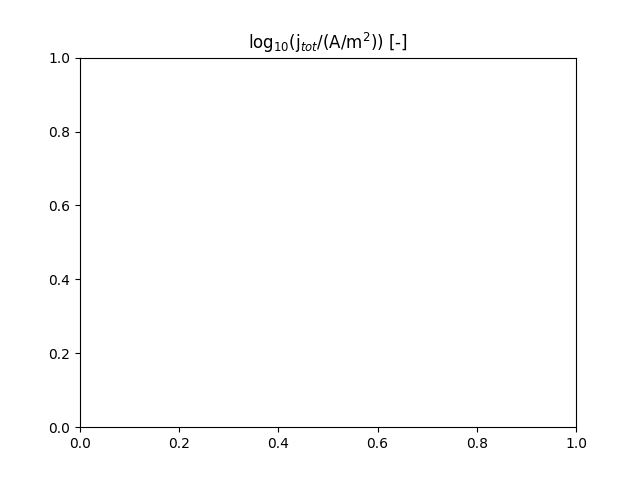

In [5]:
with open("dict_UNITS.json", "r") as file:
    output = json.load(file)

plt.figure()
plt.title(output["currdens2D"])